In [ ]:
#线上线下o2o
#一开始我以为这是关联分析问题，研究数据后发现数据格式与目标与我所想不符
#数据说明：aisles：产品摆放位置说明
#          order_products__prior：订单产品关联表
#          orders.csv: 用户下单记录表。    
#          products.csv: 产品ID分类，及其摆放位置的关系表
#          departments.csv：  产品分类表
#我们要做的是预测用户下次购买时，可能再次购买的产品。
#用户历史购买的产品，那些是用户下次购买还会购买的。
#仅将此问题算作复杂的分类问题进行研究

In [1]:
import pandas as pd 
import numpy as np 
import nltk # text preprocessing & manipulation
# from textblob import TextBlob
import matplotlib.pyplot as plt 
import seaborn as sns #作图工具
from functools import partial # to reduce df memory consumption by applying to_numeric
color = sns.color_palette() #调整作图颜色
import warnings #忽略警告
warnings.filterwarnings('ignore')
%matplotlib inline

In [ ]:
#首先读入数据

In [4]:
aisles = pd.read_csv('D:\databasework\instacart/aisles.csv/aisles.csv', engine='c')
print('Total aisles: {}'.format(aisles.shape[0]))
aisles.head()

Total aisles: 134


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
departments = pd.read_csv('D:\databasework\instacart/departments.csv/departments.csv', engine='c')
print('Total departments: {}'.format(departments.shape[0]))
departments.head()

Total departments: 21


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [6]:
products = pd.read_csv('D:\databasework\instacart\products.csv/products.csv', engine='c')
print('Total products: {}'.format(products.shape[0]))
products.head()

Total products: 49688


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
train = pd.read_csv('D:\databasework\instacart\order_products__train.csv/order_products__train.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
print('Total ordered products(train): {}'.format(train.shape[0]))
train.head(10)

Total ordered products(train): 1384617


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1
5,1,13176,6,0
6,1,47209,7,0
7,1,22035,8,1
8,36,39612,1,0
9,36,19660,2,1


In [8]:
test = pd.read_csv('D:\databasework\instacart\sample_submission.csv/sample_submission.csv', engine='c')
print('Total orders(test): {}'.format(train.shape[0]))
test.head()

Total orders(test): 1384617


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


In [86]:
prior = pd.read_csv('D:\databasework\instacart\order_products__prior.csv/order_products__prior.csv', engine='c', 
                       dtype={'order_id': np.int32, 'product_id': np.int32, 
                              'add_to_cart_order': np.int16, 'reordered': np.int8})
print('Total ordered products(prior): {}'.format(prior.shape[0]))
prior.head()

Total ordered products(prior): 32434489


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [87]:
orders = pd.read_csv('D:\databasework\instacart\orders.csv/orders.csv', engine='c', dtype={'order_id': np.int32, 
                                                           'user_id': np.int32, 'order_number': np.int32, 
                                                           'order_dow': np.int8, 'order_hour_of_day': np.int8, 
                                                           'days_since_prior_order': np.float16})
print('Total orders: {}'.format(orders.shape[0]))
orders.head()

Total orders: 3421083


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
#由于数据本身并无维度过多，缺失值严重等问题，为加深对数据的理解，我们先做数据可视化
#首先分析商品，将商品与商品分类和商品位置结合到一起
goods = pd.merge(left=pd.merge(left=products, right=departments, how='left'), right=aisles, how='left')
#处理商品名称使商品名称更加标准化
# to retain '-' and make product names more "standard"
goods.product_name = goods.product_name.str.replace(' ', '_').str.lower() 
goods.head()

,product_id,product_name,aisle_id,department_id,department,aisle
0,1,chocolate_sandwich_cookies,61,19,snacks,cookies cakes
1,2,all-seasons_salt,104,13,pantry,spices seasonings
2,3,robust_golden_unsweetened_oolong_tea,94,7,beverages,tea
3,4,smart_ones_classic_favorites_mini_rigatoni_wit...,38,1,frozen,frozen meals
4,5,green_chile_anytime_sauce,5,13,pantry,marinades meat preparation


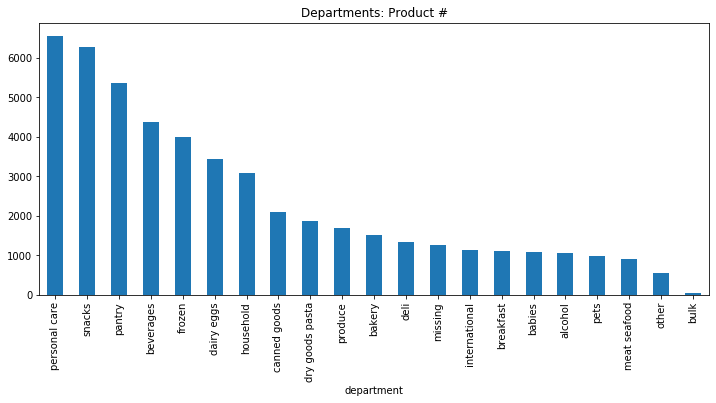

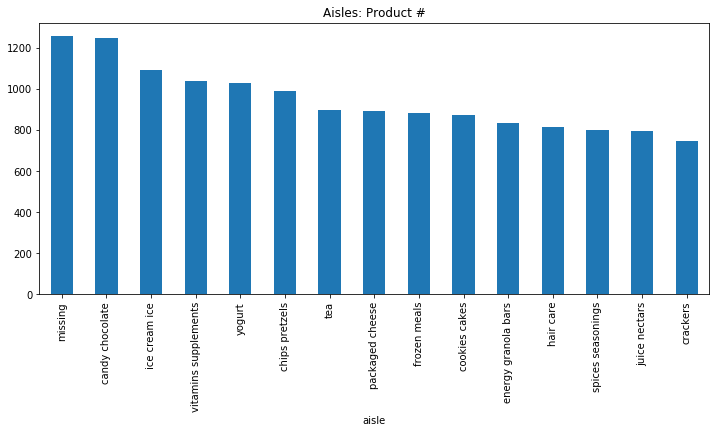

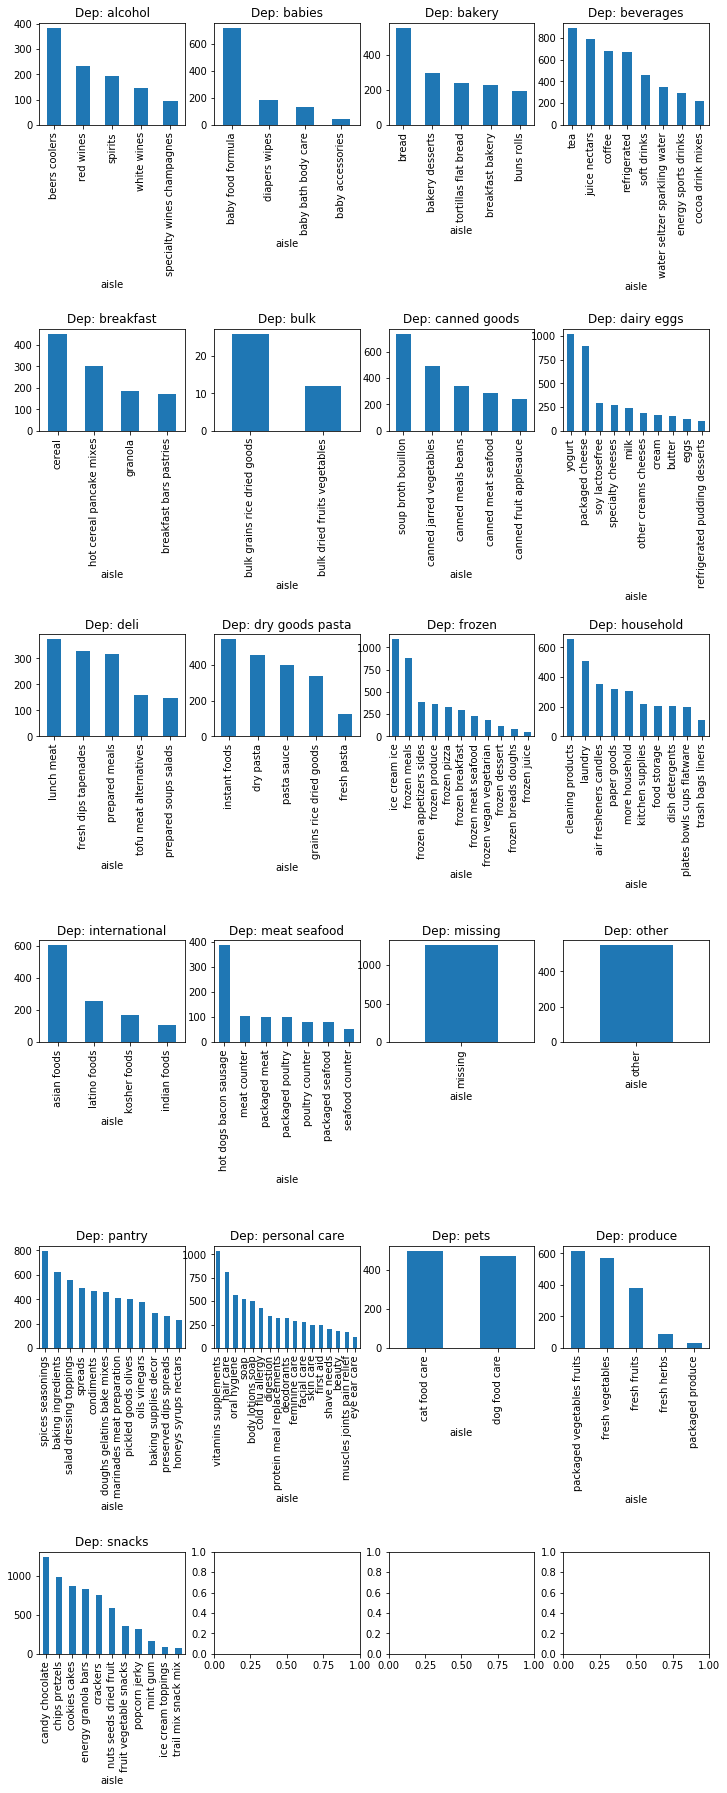

In [12]:
#基本商品信息
plt.figure(figsize=(12, 5))
goods.groupby(['department']).count()['product_id'].copy()\
.sort_values(ascending=False).plot(kind='bar', #figsize=(12, 5), 
                                   title='Departments: Product #')
#摆放位置信息前十五位
top_aisles_cnt = 15
plt.figure(figsize=(12, 5))
goods.groupby(['aisle']).count()['product_id']\
.sort_values(ascending=False)[:top_aisles_cnt].plot(kind='bar', 
                                   #figsize=(12, 5), 
                                   title='Aisles: Product #')
#记录细分类，将分类中的位置数目作图
f, axarr = plt.subplots(6, 4, figsize=(12, 30))
for i,e in enumerate(departments.department.sort_values(ascending=True)):
    axarr[i//4, i%4].set_title('Dep: {}'.format(e))
    goods[goods.department==e].groupby(['aisle']).count()['product_id']\
    .sort_values(ascending=False).plot(kind='bar', ax=axarr[i//4, i%4])
f.subplots_adjust(hspace=2)

In [14]:
from functools import partial
#将训练集和优先集合并，通过partial实现数据转换降低存储
#将数据集按索引进行分割，分为十份
indexes = np.linspace(0, len(prior), num=10, dtype=np.int32)
# 先将训练集与订单进行合并
order_details = pd.merge(
                left=train,
                 right=orders, 
                 how='left', 
                 on='order_id'
        ).apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))
# 再加入商品的详细信息
order_details = pd.merge(
                left=order_details,
                right=goods[['product_id', 
                             'aisle_id', 
                             'department_id']].apply(partial(pd.to_numeric, 
                                                             errors='ignore', 
                                                             downcast='integer')),
                how='left',
                on='product_id'
)
print(order_details.shape)

(1384617, 12)


In [15]:
#行标号由小至大分十次将prior集中的数据加入到order details中
for i in range(len(indexes)-1):
    order_details = pd.concat(
        [   
            order_details,
            pd.merge(left=pd.merge(
                            left=prior.iloc[indexes[i]:indexes[i+1], :],
                            right=goods[[
                                'product_id', 
                                 'aisle_id', 
                                 'department_id'
                            ]].apply(partial(pd.to_numeric, 
                                             errors='ignore', 
                                             downcast='integer')),
                            how='left',
                            on='product_id'
                            ),
                     right=orders, 
                     how='left', 
                     on='order_id'
                ) #.apply(partial(pd.to_numeric, errors='ignore', downcast='integer'))
        ]
    )
print('Datafame length: {}'.format(order_details.shape[0]))

# 确保测试集并未丢失
test_orders = orders[orders.eval_set == 'test']

Datafame length: 33819106


In [16]:
#单独用户，单独订单，购买过的商品
print('Unique users: {}'.format(len(set(order_details.user_id))))
print('Unique orders: {}'.format(len(set(order_details.order_id))))
print('Unique products bought: {}/{}'.format(len(set(order_details.product_id)), len(goods)))

Unique users: 206209
Unique orders: 3346083
Unique products bought: 49685/49688


In [17]:
#观察一下所有订单中没出现过的商品
unordered = goods[goods.product_id.isin(list(set(goods.product_id) - set(order_details.product_id)))]
print('never products: {}/{}'.format(unordered.shape[0], len(goods)))
unordered.head()

never products: 3/49688


,product_id,product_name,aisle_id,department_id,department,aisle
3629,3630,protein_granola_apple_crisp,57,14,breakfast,granola
7044,7045,unpeeled_apricot_halves_in_heavy_syrup,88,13,pantry,spreads
46624,46625,single_barrel_kentucky_straight_bourbon_whiskey,31,7,beverages,refrigerated


Text(0.5, 0, 'Product Name')

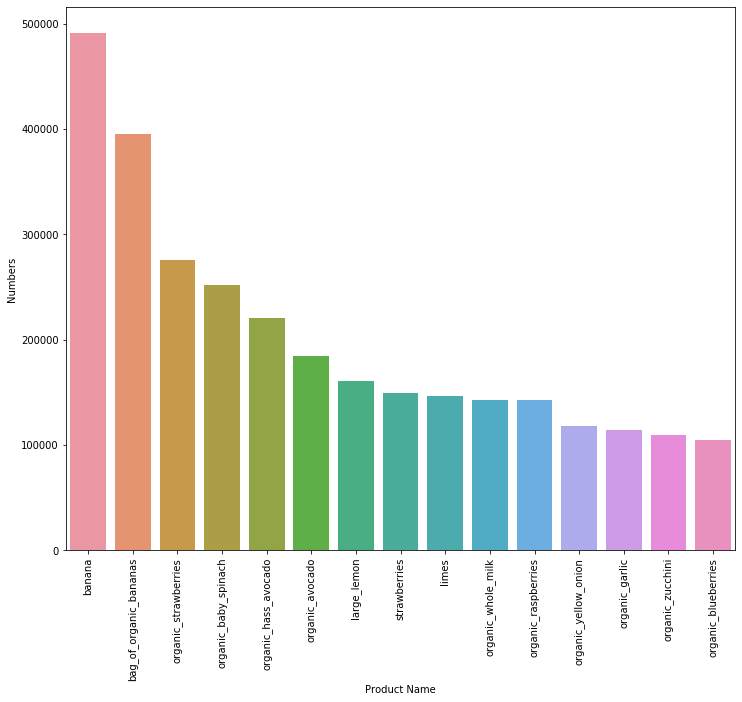

In [18]:
# 观察所有商品中最受欢迎的商品前十五位，包括原始数据中的商品。
top = 15
top_products = pd.merge(
    # to see train: 
    # left=pd.DataFrame(order_details[order_details.eval_set == 'train'].groupby(['product_id'])['order_id']\
    left=pd.DataFrame(order_details.groupby(['product_id'])['order_id']\
    .apply(lambda x: len(x.unique())).sort_values(ascending=False)[:top].reset_index('product_id')),
    right=goods,
    how='left')

f, ax = plt.subplots(figsize=(12, 10))
plt.xticks(rotation='vertical')
sns.barplot(top_products.product_name, top_products.order_id)
plt.ylabel('Numbers')
plt.xlabel('Product Name')

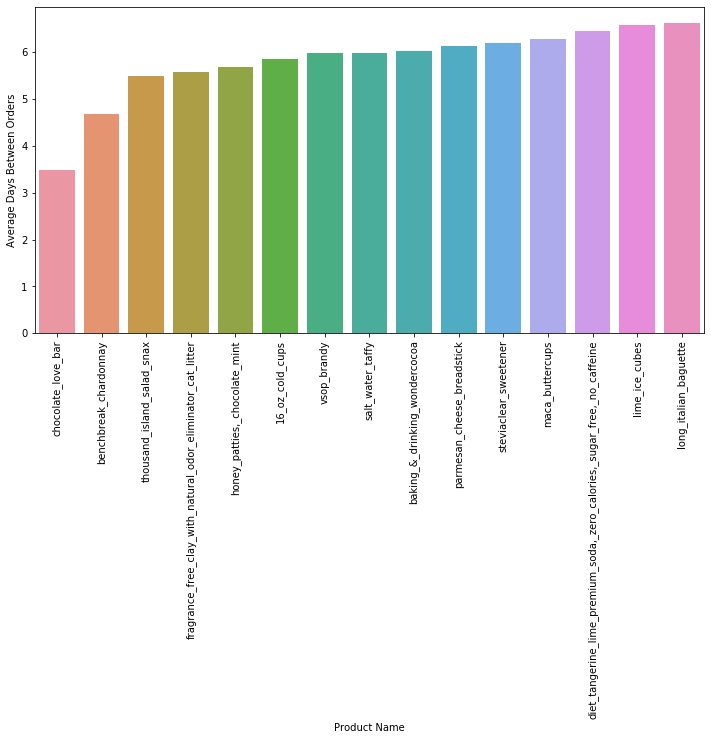

In [20]:
#观察最常购买的商品，即在用户两次购买平均间隔时间最短的商品，为限制特殊情况，将大于100位用户购买的商品列入
top = 15
customer_lower = 100

temp = order_details.groupby(['product_id'])[['days_since_prior_order', 'user_id']]\
.aggregate({'days_since_prior_order': np.mean, 'user_id': len}).reset_index()

frequent_products = pd.merge(
    left=pd.DataFrame(temp[temp.user_id > customer_lower].sort_values(['days_since_prior_order'], 
                                                                      ascending=True)[:top]),
    right=goods,
    how='left')

plt.figure(figsize=(12,6))
plt.xticks(rotation='vertical')
sns.barplot(frequent_products.product_name, frequent_products.days_since_prior_order)
plt.ylabel('Average Days Between Orders')
plt.xlabel('Product Name')
#清理内存
del temp

最相似的订单包括: 5个商品


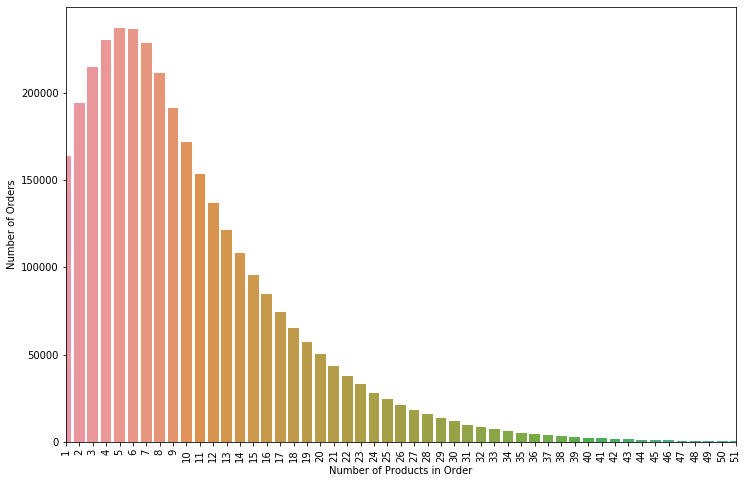

In [21]:
#观察最相似的订单，即加入购物车的相同商品数量
ord_by_prods = order_details.groupby("order_id")["add_to_cart_order"]\
.aggregate(np.max).reset_index()['add_to_cart_order'].value_counts()

print('最相似的订单包括: {}个商品'.format(
    ord_by_prods[ord_by_prods.values == ord_by_prods.max()].index.values[0]))

# plot it
plt.figure(figsize=(12, 8))
plt.xticks(rotation='vertical')
sns.barplot(ord_by_prods.index, ord_by_prods.values)
plt.ylabel('Number of Orders')
plt.xlabel('Number of Products in Order')
plt.xlim([0, 50])
pass

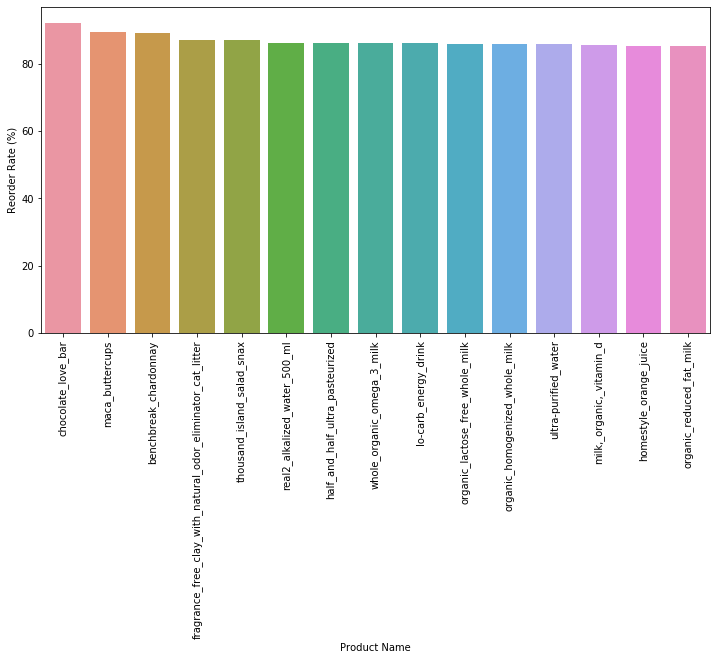

In [22]:
# 观察购买订单中复购率最高的商品前十五位
# 限制购买次数超过一百次避免异常
order_lower = 100
top = 15

mo_products = order_details.groupby('product_id')[['reordered', 'order_id']]\
.aggregate({'reordered': sum, 'order_id': len}).reset_index()
mo_products.columns = ['product_id', 'reordered', 'order_cnt']

mo_products['reorder_rate'] = mo_products['reordered'] / mo_products['order_cnt']
mo_products = mo_products[mo_products.order_cnt > order_lower].sort_values(['reorder_rate'], ascending=False)[:top]

mo_products = pd.merge(
    left=mo_products,
    right=goods,
    on='product_id')
mo_products

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(mo_products.product_name, mo_products.reorder_rate*100)
plt.ylabel('Reorder Rate (%)')
plt.xlabel('Product Name')
pass

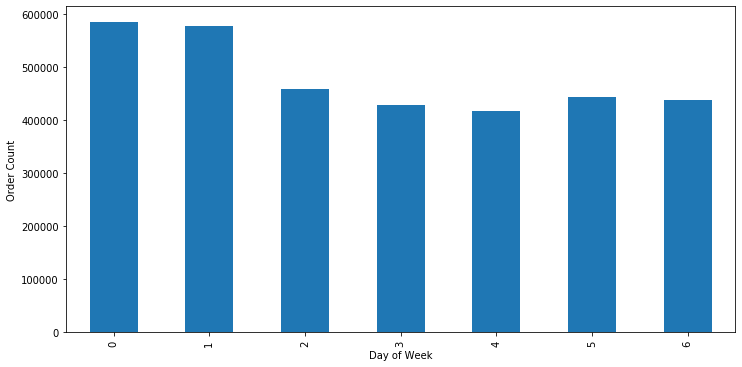

In [23]:
#观察订单是怎样按周分布的
plt.figure(figsize=(12,6))
order_details.groupby('order_dow')['order_id'].apply(lambda x: len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Day of Week')
pass

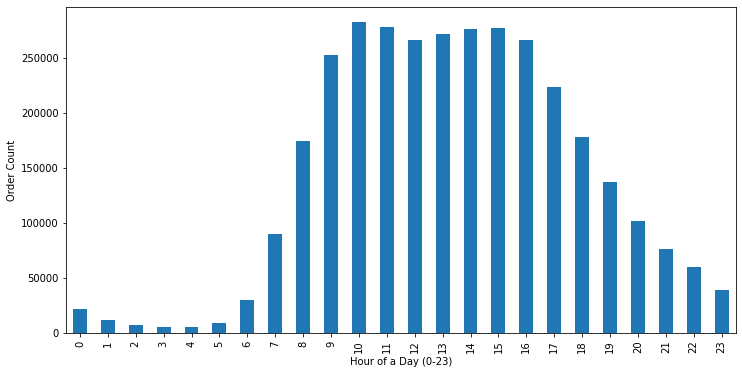

In [24]:
#观察订单按小时分布情况
plt.figure(figsize=(12,6))
order_details.groupby('order_hour_of_day')['order_id'].apply(lambda x: len(x.unique())).plot(kind='bar')
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Hour of a Day (0-23)')
pass

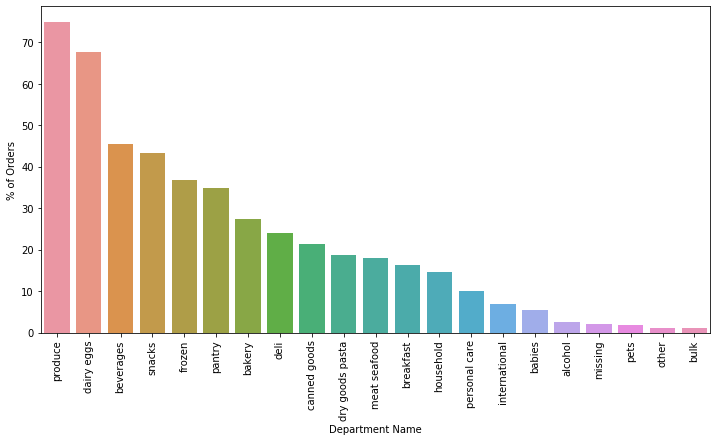

In [25]:
#包含最多商品种类的订单，用百分比表示
pop_dep = pd.merge(
    left=order_details.groupby('department_id')['order_id'].apply(lambda x: len(x.unique())).reset_index(),
    right=goods[['department_id', 'department']].drop_duplicates(),
    how='inner',
    on='department_id'
).sort_values(['order_id'], ascending=False)

total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(pop_dep.department, pop_dep.order_id / total_orders * 100)
plt.ylabel('% of Orders')
plt.xlabel('Department Name')
pass

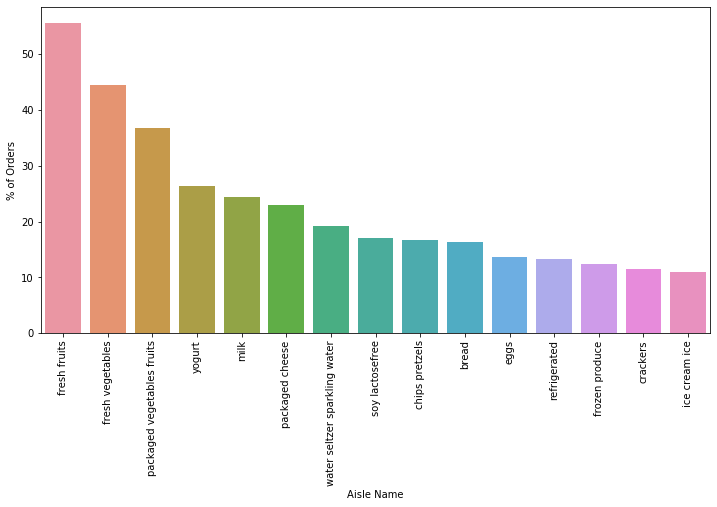

In [26]:
#包含最多商品位置的订单，用百分比表示
pop_ais = pd.merge(
    left=order_details.groupby('aisle_id')['order_id'].apply(lambda x: len(x.unique())).reset_index(),
    right=goods[['aisle_id', 'aisle']].drop_duplicates(),
    how='inner',
    on='aisle_id'
).sort_values(['order_id'], ascending=False)[:top]

total_orders = len(set(order_details.order_id))

plt.figure(figsize=(12, 6))
plt.xticks(rotation='vertical')
sns.barplot(pop_ais.aisle, pop_ais.order_id / total_orders * 100)
plt.ylabel('% of Orders')
plt.xlabel('Aisle Name')
pass

大多数用户购买了: 4 次


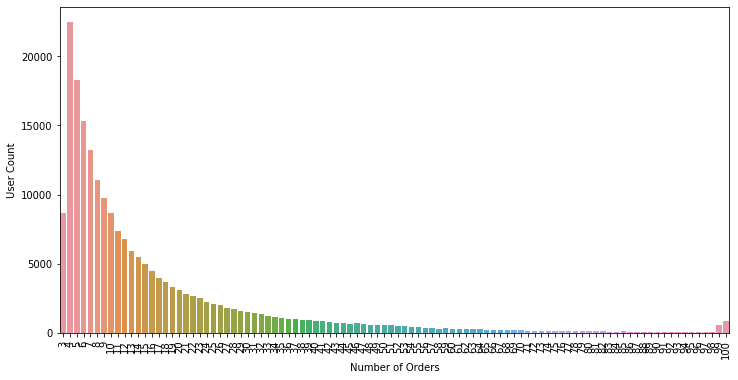

In [27]:
#观察用户创建订单数量
ocpu = order_details.groupby('user_id')['order_id']\
.apply(lambda x: len(x.unique())).reset_index().groupby('order_id').aggregate("count")

print('大多数用户购买了: {} 次'.format(
    ocpu[ocpu.user_id == ocpu.user_id.max()].index.values[0]))

plt.figure(figsize=(12, 6))
sns.barplot(ocpu.index, ocpu.user_id)
plt.xticks(rotation='vertical')
plt.ylabel('User Count')
plt.xlabel('Number of Orders')
pass

第二次订单最常出现在: 30 天


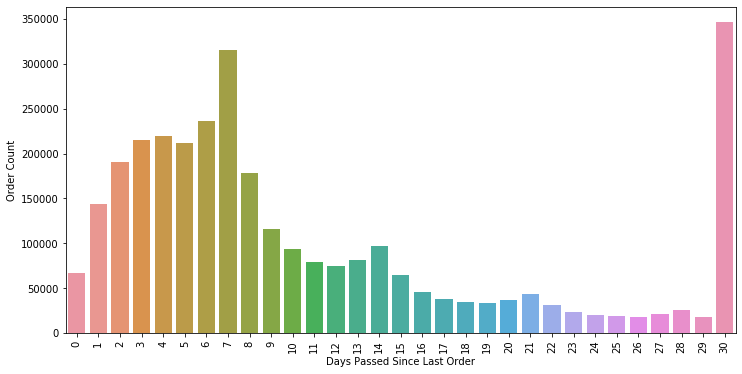

In [28]:
#观察与上一次订单间隔时间，其中三十天和七天较为常见
dtno = order_details.dropna(axis=0, 
                     subset=['days_since_prior_order']).groupby('order_id')['days_since_prior_order']\
.aggregate("mean").reset_index().apply(np.int32).groupby('days_since_prior_order').aggregate("count")

print('第二次订单最常出现在: {} 天'.format(
    dtno[dtno.order_id == dtno.order_id.max()].index.values[0]))

plt.figure(figsize=(12, 6))
sns.barplot(dtno.index, dtno.order_id)
plt.xticks(rotation='vertical')
plt.ylabel('Order Count')
plt.xlabel('Days Passed Since Last Order')
pass

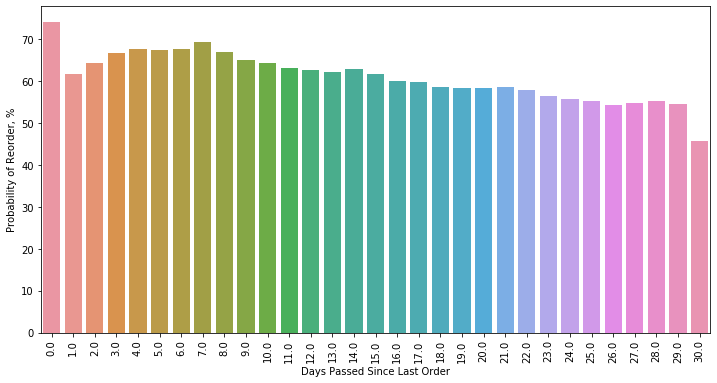

In [29]:
#观察第二次订单与复购率的关系，可以看到时间越长复购率越低
por = order_details.dropna(axis=0, subset=['days_since_prior_order'])\
.groupby('days_since_prior_order')['reordered'].aggregate("mean").reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(por.days_since_prior_order, por.reordered*100)
plt.xticks(rotation='vertical')
plt.ylabel('Probability of Reorder, %')
plt.xlabel('Days Passed Since Last Order')
pass

In [32]:
#数据可视化为我们提供了灵感，关于怎样创建新的特征变量以便更好的实现模型，进行更精准的预测。
#建立一个新函数用于添加特征变量，参数df为数据集，group_colums_list为想要作为分组依据的变量，agg_dict是字典，返回值为新的数据文件
def add_features(df, group_columns_list, agg_dict, only_new_feature=True):
        try:
            if type(group_columns_list) == list:
                pass
            else:
                raise TypeError(k + "should be a list")
        except TypeError as e:
            print(e)
            raise
        df_new = df.copy()
        grouped = df_new.groupby(group_columns_list)
        the_stats = grouped.agg(agg_dict)
        the_stats.columns = the_stats.columns.droplevel(0)
        the_stats.reset_index(inplace=True)
        if only_new_feature:
            df_new = the_stats
        else:
            df_new = pd.merge(left=df_new, right=the_stats, on=group_columns_list, how='left')
        return df_new

In [35]:
"===================商品模块============================"
# 关于商品信息，进行特征变量的创建
# 在原始数据集中加入订单信息（由于之前对数据进行了处理，这里重新进行一次）
priors_orders_detail = orders.merge(right=prior, how='inner', on='order_id')

# 建立新变量
# _product_times: 用户购买商品的次数（第几次）
priors_orders_detail.loc[:,'_product_times'] = priors_orders_detail.groupby(['user_id', 'product_id']).cumcount()+1
# _product_total_counts: 该商品被购买的总次数，即商品受欢迎程度
# _reorder_total_counts: 商品被再次购买的总次数
# _product_buy_first_time_total_count: 该商品被购买一次的总次数
# _product_order_more_than_once: 该商品被购买一次以上的总次数
agg_dict = {'user_id':{'_product_total_counts':'count'}, 
            'reordered':{'_product_reorder_total_counts':'sum'}, 
            '_product_times': {'_product_buy_first_time_total_count':lambda x: sum(x==1),
                                        '_product_buy_second_time_total_count':lambda x: sum(x==2)}}
prd = add_features(priors_orders_detail, ['product_id'], agg_dict)

# _prod_reorder_prob: 商品重复购买概率（在购买一次之后的情况下）
# _prod_reorder_ratio: 商品复购率
prd['_prod_reorder_prob'] = prd._product_buy_second_time_total_count / prd._product_buy_first_time_total_count
prd['_prod_reorder_ratio'] = prd._product_reorder_total_counts / prd._product_total_counts
prd['_prod_reorder_times'] = 1 + prd._product_reorder_total_counts / prd._product_buy_first_time_total_count

prd.head()

,product_id,_product_total_counts,_product_reorder_total_counts,_product_buy_first_time_total_count,_product_buy_second_time_total_count,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times
0,1,1852,1136.0,716,276,0.385475,0.613391,2.586592
1,2,90,12.0,78,8,0.102564,0.133333,1.153846
2,3,277,203.0,74,36,0.486486,0.732852,3.743243
3,4,329,147.0,182,64,0.351648,0.446809,1.807692
4,5,15,9.0,6,4,0.666667,0.600000,2.500000


In [36]:
"====================用户模块================================"
# _user_total_orders: 用户的总订单数
# _user_sum_days_since_prior_order: 距离上次购买时间(和)
# _user_mean_days_since_prior_order: 距离上次购买时间(均值)
agg_dict_2 = {'order_number':{'_user_total_orders':'max'},
              'days_since_prior_order':{'_user_sum_days_since_prior_order':'sum', 
                                        '_user_mean_days_since_prior_order': 'mean'}}
users = add_features(orders[orders.eval_set == 'prior'], ['user_id'], agg_dict_2)

#这一部分是在订单中独立计算的
users.head()

,user_id,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order
0,1,10,176.0,19.562500
1,2,14,198.0,15.234375
2,3,12,133.0,12.093750
3,4,5,55.0,13.750000
4,5,4,40.0,13.335938


In [37]:
# _user_reorder_ratio: 复购的总次数 / 第一单后买后的总次数
# _user_total_products: 用户购买的商品总数
# _user_distinct_products: 用户购买的单独商品数(种类)
agg_dict_3 = {'reordered':
              {'_user_reorder_ratio': 
               lambda x: sum(priors_orders_detail.ix[x.index,'reordered']==1)/
                         sum(priors_orders_detail.ix[x.index,'order_number'] > 1)}, #重复购买率
              'product_id':{'_user_total_products':'count', 
                            '_user_distinct_products': lambda x: x.nunique()}}
us = add_features(priors_orders_detail, ['user_id'], agg_dict_3)
users = users.merge(us, how='inner')

# _user_average_basket：平均每单的商品数
users['_user_average_basket'] = users._user_total_products / users._user_total_orders

#提取非原始数据集中的数据
us = orders[orders.eval_set != "prior"][['user_id', 'order_id', 'eval_set', 'days_since_prior_order']]
us.rename(index=str, columns={'days_since_prior_order': 'time_since_last_order'}, inplace=True)

users = users.merge(us, how='inner')

users.head()

,user_id,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order
0,1,10,176.0,19.562500,0.759259,59,18,5.900000,1187899,train,14.0
1,2,14,198.0,15.234375,0.510989,195,102,13.928571,1492625,train,30.0
2,3,12,133.0,12.093750,0.705128,88,33,7.333333,2774568,test,11.0
3,4,5,55.0,13.750000,0.071429,18,17,3.600000,329954,test,30.0
4,5,4,40.0,13.335938,0.538462,37,23,9.250000,2196797,train,6.0


In [38]:
"=================将数据整合成为可供分析的数据集======================="
# _up_order_count: 用户购买该商品的次数
# _up_first_order_number: 用户第一次购买该商品的订单数
# _up_last_order_number: 用户最后一次购买该商品的订单数
# _up_average_cart_position: 该商品被添加到购物篮中的平均位置
agg_dict_4 = {'order_number':{'_up_order_count': 'count', 
                              '_up_first_order_number': 'min', 
                              '_up_last_order_number':'max'}, 
              'add_to_cart_order':{'_up_average_cart_position': 'mean'}}

data = add_features(df=priors_orders_detail, group_columns_list=['user_id', 'product_id'], agg_dict=agg_dict_4)

data = data.merge(prd, how='inner', on='product_id').merge(users, how='inner', on='user_id')
# 产品用户数据，与产品，用户特征合并。

# _up_order_rate：商品购买率：该商品购买次数 / 总的订单数
data['_up_order_rate'] = data._up_order_count / data._user_total_orders

# merge一下
train = train.merge(right=orders[['order_id', 'user_id']], how='left', on='order_id')
data = data.merge(train[['user_id', 'product_id', 'reordered']], on=['user_id', 'product_id'], how='left')

data.head()

#释放内存
del priors_orders_detail, orders

In [42]:
data.head(10)

,user_id,product_id,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_product_total_counts,_product_reorder_total_counts,_product_buy_first_time_total_count,_product_buy_second_time_total_count,...,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,order_id,eval_set,time_since_last_order,_up_order_rate,reordered
0,1,196,10,1,10,1.400000,35791,27791.0,8000,4660,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,1.0,1.0
1,1,10258,9,2,10,3.333333,1946,1389.0,557,308,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.9,1.0
2,1,10326,1,5,5,5.000000,5526,3603.0,1923,1003,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.1,NaN
3,1,12427,10,1,10,3.300000,6476,4797.0,1679,889,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,1.0,NaN
4,1,13032,3,2,10,6.333333,3751,2465.0,1286,617,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.3,1.0
5,1,13176,2,2,5,6.000000,379450,315913.0,63537,45231,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.2,NaN
6,1,14084,1,1,1,2.000000,15935,12923.0,3012,1895,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.1,NaN
7,1,17122,1,5,5,6.000000,13880,9377.0,4503,2375,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.1,NaN
8,1,25133,8,3,10,4.000000,6196,4586.0,1610,935,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.8,1.0
9,1,26088,2,1,2,4.500000,2523,1360.0,1163,471,...,19.5625,0.759259,59,18,5.9,1187899,train,14.0,0.2,1.0


In [ ]:
#该数据集已被分为训练集和测试集
train = data.loc[data.eval_set == "train",:]
train.drop(['eval_set', 'user_id', 'product_id', 'order_id'], axis=1, inplace=True)
train.loc[:, 'reordered'] = train.reordered.fillna(0)

X_test = data.loc[data.eval_set == "test",:]

X_train, X_val, y_train, y_val = train_test_split(train.drop('reordered', axis=1), train.reordered, test_size=0.9, random_state=42)

In [46]:
X_train.head(10)

,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_product_total_counts,_product_reorder_total_counts,_product_buy_first_time_total_count,_product_buy_second_time_total_count,_prod_reorder_prob,_prod_reorder_ratio,_prod_reorder_times,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,time_since_last_order,_up_order_rate
2785200,1,8,8,31.000000,2145,529.0,1616,305,0.188738,0.246620,1.327351,42,355.0,8.656250,0.668599,1062,370,25.285714,6.0,0.023810
5090964,5,1,22,24.000000,45530,25877.0,19653,8945,0.455147,0.568351,2.316695,23,292.0,13.273438,0.794872,593,159,25.782609,7.0,0.217391
792885,1,12,12,20.000000,5712,2655.0,3057,1063,0.347727,0.464811,1.868499,21,226.0,11.296875,0.548747,365,168,17.380952,7.0,0.047619
13078912,2,3,4,2.000000,1208,610.0,598,233,0.389632,0.504967,2.020067,4,60.0,20.000000,0.416667,19,14,4.750000,30.0,0.500000
7103231,4,7,32,3.750000,3076,2041.0,1035,504,0.486957,0.663524,2.971981,34,331.0,10.031250,0.608696,409,171,12.029412,0.0,0.117647
12387549,1,1,1,10.000000,11029,6336.0,4693,1921,0.409333,0.574485,2.350096,42,350.0,8.539062,0.733634,456,131,10.857143,7.0,0.023810
10489517,6,1,8,2.333333,2823,1747.0,1076,452,0.420074,0.618845,2.623606,8,119.0,17.000000,0.816901,95,37,11.875000,13.0,0.750000
11773762,1,3,3,3.000000,3744,2072.0,1672,625,0.373804,0.553419,2.239234,10,117.0,13.000000,0.296875,69,50,6.900000,17.0,0.100000
4974362,1,17,17,2.000000,2055,981.0,1074,387,0.360335,0.477372,1.913408,55,347.0,6.425781,0.635108,513,191,9.327273,5.0,0.018182
7796057,2,2,5,22.000000,165,37.0,128,18,0.140625,0.224242,1.289062,6,122.0,24.406250,0.361345,159,116,26.500000,16.0,0.333333


In [47]:
X_val.head

,_up_order_count,_up_first_order_number,_up_last_order_number,_up_average_cart_position,_product_total_counts,_product_reorder_total_counts,_product_buy_first_time_total_count,_product_buy_second_time_total_count,_prod_reorder_prob,_prod_reorder_ratio,...,_user_total_orders,_user_sum_days_since_prior_order,_user_mean_days_since_prior_order,_user_reorder_ratio,_user_total_products,_user_distinct_products,_user_average_basket,time_since_last_order,_up_order_rate,reorder
8607471,1,1,1,11.000000,5497,3920.0,1577,848,0.537730,0.713116,...,5,96.0,24.000000,0.222222,48,40,9.600000,14.0,0.200000,0.0
6964868,1,8,8,4.000000,4721,2976.0,1745,835,0.478510,0.630375,...,8,106.0,15.140625,0.442857,79,48,9.875000,21.0,0.125000,1.0
4482769,1,1,1,5.000000,8519,3045.0,5474,1434,0.261966,0.357436,...,4,60.0,20.000000,0.250000,47,39,11.750000,2.0,0.250000,1.0
12311404,1,12,12,5.000000,33,6.0,27,2,0.074074,0.181818,...,38,348.0,9.406250,0.609499,392,161,10.315789,6.0,0.026316,0.0
12704620,1,9,9,5.000000,1050,407.0,643,172,0.267496,0.387619,...,11,124.0,12.398438,0.276596,50,37,4.545455,21.0,0.090909,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225824,1,5,5,22.000000,10434,4024.0,6410,1940,0.302652,0.385662,...,50,358.0,7.304688,0.542536,632,294,12.640000,5.0,0.020000,0.0
5916446,2,17,18,2.500000,4638,2696.0,1942,822,0.423275,0.581285,...,19,248.0,13.781250,0.680233,174,57,9.157895,27.0,0.105263,0.0
3124904,1,4,4,8.000000,3527,1189.0,2338,586,0.250642,0.337114,...,57,350.0,6.250000,0.659906,658,235,11.543860,12.0,0.017544,0.0
9236338,1,24,24,8.000000,1354,585.0,769,253,0.328999,0.432053,...,52,354.0,6.941406,0.812636,465,92,8.942308,5.0,0.019231,0.0


In [48]:
y_val.head(10)

8607471     0.0
6964868     1.0
4482769     1.0
12311404    0.0
12704620    0.0
3602123     0.0
11897168    0.0
1546427     0.0
6626640     0.0
4749516     0.0
Name: reordered, dtype: float64

[0]	train-logloss:0.51309
[10]	train-logloss:0.25497
[20]	train-logloss:0.24728
[30]	train-logloss:0.24469
[40]	train-logloss:0.24309
[50]	train-logloss:0.24158
[60]	train-logloss:0.24043
[70]	train-logloss:0.23956
[79]	train-logloss:0.23891


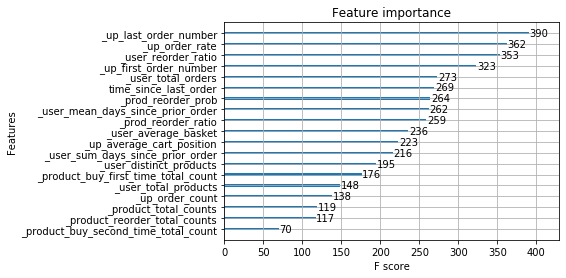

In [43]:
#仅使用原始模型默认参数观察
#xgboost
import xgboost
d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.3
    ,"max_depth"        : 6
    ,"min_child_weight" :1
    ,"gamma"            :0
    ,"subsample"        :1
    ,"colsample_bytree" :1
    ,"alpha"            :0
    ,"lambda"           :1
}
watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [52]:
X_val=X_val.drop(['reorder'], axis=1)# xgboost使用时添加了pre,所以这里删除
#predict 预测
pre_data = xgboost.DMatrix(X_val, y_val)
predict_xg=bst.predict(pre_data)
X_val['reorder']=y_val
X_val['pre']=predict_xg

precision=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['pre']>0.5]))   # predict score>0.5 and lables=1 nums divied predict score>0.5 nums
recall=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['reorder']==1]))     # predict score>0.5 and lables=1 nums divied lables=1
f1_score=2*(precision*recall)/(precision+recall)

print (f1_score)

0.2642196426375099


In [54]:
#lightgbm
import numpy as np
import lightgbm as lgb
labels = np.array(y_train, dtype=np.int8)
d_train = lgb.Dataset(X_train, label=labels)  # , 'order_hour_of_day', 'dow'    
params = {
    'task': 'train',
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': {'binary_logloss'},
    'num_leaves': 96,
    'max_depth': 10,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.95,
    'bagging_freq': 5
}
ROUNDS = 100
watchlist=[d_train]
lgb = lgb.train(params=params, train_set=d_train, num_boost_round=ROUNDS,valid_sets=watchlist,verbose_eval=10)

[10]	training's binary_logloss: 0.26178
[20]	training's binary_logloss: 0.25136
[30]	training's binary_logloss: 0.247511
[40]	training's binary_logloss: 0.245054
[50]	training's binary_logloss: 0.243274
[60]	training's binary_logloss: 0.242006
[70]	training's binary_logloss: 0.240827
[80]	training's binary_logloss: 0.239781
[90]	training's binary_logloss: 0.238846
[100]	training's binary_logloss: 0.237911


In [57]:
X_val=X_val.drop(['reorder'], axis=1)# xgboost使用时添加了pre,所以这里删除
predict_lgb=lgb.predict(X_val) #X_val 类型string/numpy array/scipy.sparse

X_val['reorder']=y_val
X_val['pre']=predict_lgb

precision=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['pre']>0.5]))   # predict score>0.5 and lables=1 nums divied predict score>0.5 nums
recall=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['reorder']==1]))     # predict score>0.5 and lables=1 nums divied lables=1
f1_score=2*(precision*recall)/(precision+recall)
print (f1_score)

0.2663570903498198


In [61]:
X_val=X_val.drop(['reorder','pre'], axis=1)
#random forest
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)
predict_tree=forest.predict(X_val)

In [62]:
X_val['reorder']=y_val
X_val['pre']=predict_tree

precision=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['pre']>0.5]))   # predict score>0.5 and lables=1 nums divied predict score>0.5 nums
recall=float(len(X_val[(X_val['pre']>0.5) & (X_val['reorder']==1)]))/\
          float(len(X_val[X_val['reorder']==1]))     # predict score>0.5 and lables=1 nums divied lables=1
f1_score=2*(precision*recall)/(precision+recall)
print (f1_score)

0.23044927386512543


In [76]:
y_val

8607471     0.0
6964868     1.0
4482769     1.0
12311404    0.0
12704620    0.0
           ... 
2225824     0.0
5916446     0.0
3124904     0.0
9236338     0.0
2632604     0.0
Name: reordered, Length: 7627195, dtype: float64

In [69]:
predict_lgb

array([0.05542424, 0.20726735, 0.03446888, ..., 0.00556963, 0.0068178 ,
       0.37872016])

In [80]:
predict_xgboost = [round(value) for value in predict_xg]

In [82]:
predict_lightgbm = [round(value) for value in predict_lgb]

In [81]:
from sklearn.metrics import classification_report
#我对于f1score的计算还是有些疑问，用系统方法算一下
from sklearn.metrics import f1_score
print(classification_report(y_val,predict_xgboost))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95   6880962
         1.0       0.63      0.17      0.26    746233

    accuracy                           0.91   7627195
   macro avg       0.77      0.58      0.61   7627195
weighted avg       0.89      0.91      0.88   7627195



In [83]:
print(classification_report(y_val, predict_lightgbm))

              precision    recall  f1-score   support

         0.0       0.92      0.99      0.95   6880962
         1.0       0.64      0.17      0.27    746233

    accuracy                           0.91   7627195
   macro avg       0.78      0.58      0.61   7627195
weighted avg       0.89      0.91      0.88   7627195



In [78]:
print(classification_report(y_val, predict_tree))

              precision    recall  f1-score   support

         0.0       0.91      0.99      0.95   6880962
         1.0       0.61      0.14      0.23    746233

    accuracy                           0.91   7627195
   macro avg       0.76      0.57      0.59   7627195
weighted avg       0.88      0.91      0.88   7627195



In [88]:
#由于我对模型认识不够深刻，所以参数部分未进行调整，我研究了案例中的众多内核，看到图像如下
#接下来尝试进行PCA,由于该项对于数据预测没有联系，所以并未加入到模型当中，仅作数据分析
lprior = prior[0:300000]
order_prior = pd.merge(lprior,orders,on=['order_id','order_id'])
order_prior = order_prior.sort_values(by=['user_id','order_id'])
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
221645,23391,13198,1,1,7,prior,17,0,10,28.0
221646,23391,42803,2,1,7,prior,17,0,10,28.0
221647,23391,8277,3,1,7,prior,17,0,10,28.0
221648,23391,37602,4,1,7,prior,17,0,10,28.0
221649,23391,40852,5,1,7,prior,17,0,10,28.0


In [89]:
print(aisles.shape)

(134, 2)


In [90]:
_mt = pd.merge(lprior,products, on = ['product_id','product_id'])
_mt = pd.merge(_mt,orders,on=['order_id','order_id'])
mt = pd.merge(_mt,aisles,on=['aisle_id','aisle_id'])
mt.head(10)

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,aisle
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0,eggs
1,26,33120,5,0,Organic Egg Whites,86,16,153404,prior,2,0,16,7.0,eggs
2,120,33120,13,0,Organic Egg Whites,86,16,23750,prior,11,6,8,10.0,eggs
3,327,33120,5,1,Organic Egg Whites,86,16,58707,prior,21,6,9,8.0,eggs
4,390,33120,28,1,Organic Egg Whites,86,16,166654,prior,48,0,12,9.0,eggs
5,537,33120,2,1,Organic Egg Whites,86,16,180135,prior,15,2,8,3.0,eggs
6,582,33120,7,1,Organic Egg Whites,86,16,193223,prior,6,2,19,10.0,eggs
7,608,33120,5,1,Organic Egg Whites,86,16,91030,prior,11,3,21,12.0,eggs
8,623,33120,1,1,Organic Egg Whites,86,16,37804,prior,63,3,12,3.0,eggs
9,689,33120,4,1,Organic Egg Whites,86,16,108932,prior,16,1,13,3.0,eggs


In [91]:
mt['product_name'].value_counts()[0:10]

Banana                    4432
Bag of Organic Bananas    3563
Organic Strawberries      2370
Organic Baby Spinach      2242
Organic Hass Avocado      1985
Organic Avocado           1626
Large Lemon               1380
Strawberries              1343
Organic Raspberries       1293
Limes                     1270
Name: product_name, dtype: int64

In [92]:
len(mt['product_name'].unique())

24836

In [93]:
prior.shape

(32434489, 4)

In [94]:
len(mt['aisle'].unique())

134

In [95]:
mt['aisle'].value_counts()[0:10]

fresh fruits                     33755
fresh vegetables                 31004
packaged vegetables fruits       16319
yogurt                           13477
packaged cheese                   9133
milk                              8254
water seltzer sparkling water     7634
chips pretzels                    6581
soy lactosefree                   5965
bread                             5457
Name: aisle, dtype: int64

In [96]:
cust_prod = pd.crosstab(mt['user_id'], mt['aisle'])
cust_prod.head(100)

aisle,air fresheners candles,asian foods,baby accessories,baby bath body care,baby food formula,bakery desserts,baking ingredients,baking supplies decor,beauty,beers coolers,...,spreads,tea,tofu meat alternatives,tortillas flat bread,trail mix snack mix,trash bags liners,vitamins supplements,water seltzer sparkling water,white wines,yogurt
user_id,,,,,,,,,,,,,,,,,,,,,
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
13,0,0,0,0,0,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
23,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,4
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,4
36,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
824,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
849,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
854,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
cust_prod.shape

(25831, 134)

In [98]:
from sklearn.decomposition import PCA
pca = PCA(n_components=6)
pca.fit(cust_prod)
#将数据变换到前六个主成分的方向上
pca_samples = pca.transform(cust_prod)

In [99]:
ps = pd.DataFrame(pca_samples)
ps.head()

,0,1,2,3,4,5
0,-0.286251,1.005868,-1.030293,-0.898988,-0.587789,-0.998539
1,-1.972748,-0.487659,-0.120542,0.213075,0.046088,-0.181995
2,-1.168974,1.284089,3.228124,0.594040,-0.648775,-1.091864
3,-1.433967,1.250081,3.261985,1.237743,-0.353434,-0.346514
4,-2.070709,-0.422148,-0.101553,0.278132,0.006022,-0.097416


(25831, 2)
          4         1
0 -0.587789  1.005868
1  0.046088 -0.487659
2 -0.648775  1.284089
3 -0.353434  1.250081
4  0.006022 -0.422148


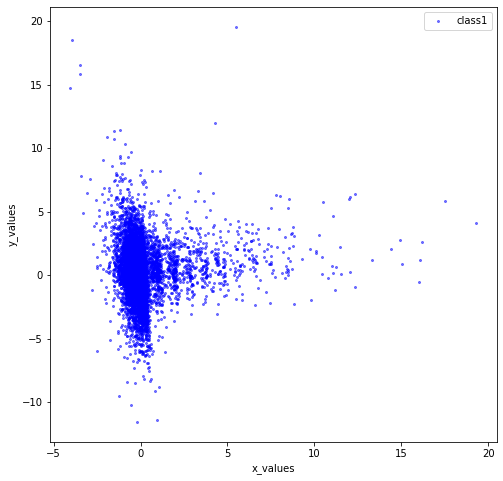

In [100]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps[[4,1]])
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[4], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [101]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

clusterer = KMeans(n_clusters=4,random_state=42).fit(tocluster)
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(tocluster)
print(centers)

[[-0.00793648 -2.39936985]
 [-0.04626375 -0.15452148]
 [-0.24952891  2.06102735]
 [ 5.55595831  1.45663524]]


In [102]:
print (c_preds[0:100])

[2 1 2 2 1 1 1 1 1 1 0 1 2 1 1 3 1 1 2 1 1 1 1 1 1 2 0 1 1 2 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 1 1 2 1 1 1 2 1 1 1 2 1 1 1 0 1 1 1 1 1 1 1 0 0 1 1 1 1
 2 2 0 1 1 1 1 1 2 2 1 1 0 2 1 1 1 1 1 2 1 1 2 1 1 1]


['purple', 'blue', 'purple', 'purple', 'blue', 'blue', 'blue', 'blue', 'blue', 'blue']


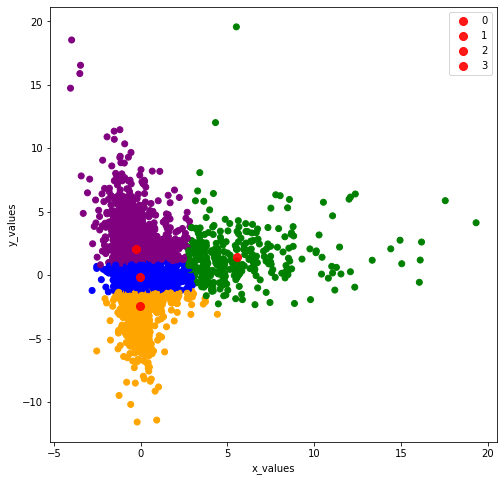

In [103]:
import matplotlib
fig = plt.figure(figsize=(8,8))
colors = ['orange','blue','purple','green']
colored = [colors[k] for k in c_preds]
print (colored[0:10])
plt.scatter(tocluster[4],tocluster[1],  color = colored)
for ci,c in enumerate(centers):
    plt.plot(c[0], c[1], 'o', markersize=8, color='red', alpha=0.9, label=''+str(ci))

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()